<a href="https://colab.research.google.com/github/tylergusmyers/ML_token_prices/blob/main/ETH_lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.linear_model import LogisticRegression


In [2]:
from google.colab import files
uploaded = files.upload()

Saving ETH.csv to ETH.csv


In [3]:
eth_df = pd.read_csv(
    Path('ETH.csv'), 
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True
)

eth_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [4]:
close_df = eth_df.loc[:, ["Close"]]
close_df.head()

,Close
Date,
2017-11-09,320.884003
2017-11-10,299.252991
2017-11-11,314.681000
2017-11-12,307.907990
2017-11-13,316.716003


In [5]:
# Generate the returns using pct_change
close_df["Actual Returns"] = close_df["Close"].pct_change()
close_df = close_df.dropna()

display(close_df.head())

,Close,Actual Returns
Date,,
2017-11-10,299.252991,-0.067411
2017-11-11,314.681000,0.051555
2017-11-12,307.907990,-0.021523
2017-11-13,316.716003,0.028606
2017-11-14,337.631012,0.066037


In [43]:
short_window = 4
long_window = 100

# Create the fast and slow window columns
close_df['SMA_Fast'] = close_df['Close'].rolling(window=short_window).mean()
close_df['SMA_Slow'] = close_df['Close'].rolling(window=long_window).mean()

close_df = close_df.dropna()

display(close_df.head())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2019-05-10,173.142746,0.016756,171.044720,145.697036,1.0,-0.016756
2019-05-11,194.304337,0.122220,177.171139,146.569469,1.0,0.122220
2019-05-12,187.325317,-0.035918,181.265427,147.366625,-1.0,-0.035918
2019-05-13,196.846283,0.050826,187.904671,148.230785,1.0,-0.050826
2019-05-14,217.148575,0.103138,198.906128,149.327344,1.0,0.103138


In [33]:
# Create the 'Signal' column for positive or negative returns
close_df['Signal'] = 0.0
close_df.loc[(close_df['Actual Returns'] >= 0), 'Signal'] = 1
close_df.loc[(close_df['Actual Returns'] < 0), 'Signal'] = -1

display(close_df.head())

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2019-01-31,107.061012,-0.016955,107.039184,333.592881,-1.0,-0.016955
2019-02-01,107.609787,0.005126,107.294138,332.667200,1.0,-0.005126
2019-02-02,110.430260,0.026210,108.502150,331.700275,1.0,0.026210
2019-02-03,107.492668,-0.026601,108.148432,330.730163,-1.0,-0.026601
2019-02-04,107.821602,0.003060,108.338579,329.708759,1.0,-0.003060


In [34]:
close_df['Signal'].value_counts()
close_df['Strategy Returns'] = close_df['Actual Returns'] * close_df['Signal'].shift()

display(close_df.head())
close_df.dtypes

,Close,Actual Returns,SMA_Fast,SMA_Slow,Signal,Strategy Returns
Date,,,,,,
2019-01-31,107.061012,-0.016955,107.039184,333.592881,-1.0,NaN
2019-02-01,107.609787,0.005126,107.294138,332.667200,1.0,-0.005126
2019-02-02,110.430260,0.026210,108.502150,331.700275,1.0,0.026210
2019-02-03,107.492668,-0.026601,108.148432,330.730163,-1.0,-0.026601
2019-02-04,107.821602,0.003060,108.338579,329.708759,1.0,-0.003060


Close               float64
Actual Returns      float64
SMA_Fast            float64
SMA_Slow            float64
Signal              float64
Strategy Returns    float64
dtype: object

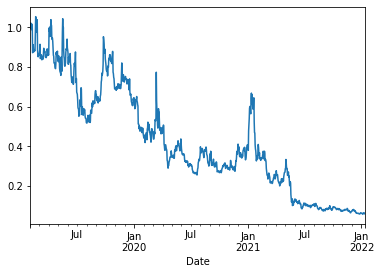

In [35]:
(1 + close_df['Strategy Returns']).cumprod().plot()

In [36]:
# Assign sma_fast and sma_slow columns X
X = close_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()
X.head()

# Create the target set 
y = close_df['Signal']
y.value_counts()

 1.0    579
-1.0    499
Name: Signal, dtype: int64

In [37]:
# Select start of training period
training_begin = X.index.min()
print(training_begin)

# Select the ending period
training_end = X.index.min() + DateOffset(months=8)
print(training_end)

2019-02-01 00:00:00
2019-10-01 00:00:00


In [38]:
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

X_train.head()

X_test = X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]

X_test.head()

,SMA_Fast,SMA_Slow
Date,,
2019-10-02,175.572250,181.000256
2019-10-03,177.106655,181.296754
2019-10-04,178.280621,181.569770
2019-10-05,177.558819,181.852521
2019-10-06,177.311592,182.123219


In [39]:
# StandardScaler instance and scale the X_train
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled[:3]

array([[-1.61975836,  2.54934891],
       [-1.61505171,  2.53005757],
       [-1.59275081,  2.50990668]])

In [40]:
logistic_regression_model = LogisticRegression()


In [41]:
model = logistic_regression_model.fit(X_train_scaled, y_train)

pred = model.predict(X_test_scaled)
pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

In [42]:
lr_classification_report = classification_report(y_test, pred)
print(lr_classification_report)

              precision    recall  f1-score   support

        -1.0       0.00      0.00      0.00       382
         1.0       0.54      1.00      0.70       452

    accuracy                           0.54       834
   macro avg       0.27      0.50      0.35       834
weighted avg       0.29      0.54      0.38       834



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
lr_predictions_df = pd.DataFrame(index=X_test.index)
lr_predictions_df['Predicted'] = pred

lr_predictions_df['Actual Returns'] = close_df["Actual Returns"]

lr_predictions_df['Strategy Returns'] = pred * lr_predictions_df['Actual Returns']

lr_predictions_df.head()

,Predicted,Actual Returns,Strategy Returns
Date,,,
2018-12-09,-1.0,0.032361,-0.032361
2018-12-10,-1.0,-0.036329,0.036329
2018-12-11,-1.0,-0.029889,0.029889
2018-12-12,-1.0,0.018528,-0.018528
2018-12-13,-1.0,-0.044749,0.044749


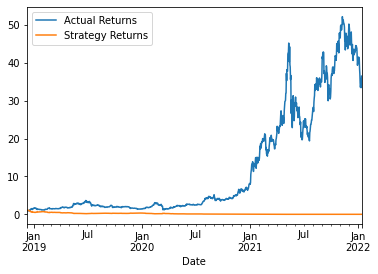

In [31]:
(1 + lr_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()